In [3]:
from defi.amm import amm
import numpy as np
from scipy.stats import norm

import matplotlib.pyplot as plt
# plt.style.use('paper.mplstyle')

import seaborn as sns
sns.set_theme(style="ticks")

import statsmodels.api as sm
import matplotlib.ticker as mtick
import pickle
import pandas as pd

import cvxpy as cp
import numpy as np
from scipy.linalg import sqrtm
from tqdm import tqdm
import torch
import copy
from scipy.stats import kurtosis

# Generate returns

In [39]:
# 1 pool example

PARAM = 1e-1

N_pools = 2
params = {'N_pools': N_pools,
          'Rx0': 100 * np.ones(N_pools),
          'Ry0': 1000 * np.ones(N_pools),
          'phi': np.array([0.03, 0.03]),
          'x_0': 600,
          'alpha': 0.05,
          'q': 0.85,
          'zeta': 0.05,
          'batch_size': 1_000,
          'kappa': np.array([PARAM, PARAM, PARAM]),
          'sigma': np.array([PARAM, PARAM, PARAM]),
          'p': np.array([0.3, 0.3, 0.3]),
          'T': 10,
          'seed': 4294967143}

locals().update(params)

In [ ]:
log_rets = []
results = []

ws = np.linspace(1e-4, 1-1e-4, 21)

for w in ws:
    locals().update(params)
    pools = amm(Rx=Rx0, Ry=Ry0, phi=phi)

    xs_0 = x_0 * np.array([w, 1-w])
    l = pools.swap_and_mint(xs_0)

    np.random.seed(seed)
    end_pools, Rx_t, Ry_t, v_t, event_type_t, event_direction_t = pools.simulate(kappa, p, sigma, T=T, batch_size=batch_size)

    x_T = np.sum(np.array([pool.burn_and_swap(l) for pool in end_pools]), axis=1)
    log_ret = np.log(x_T) - np.log(x_0)

    results += [log_ret]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


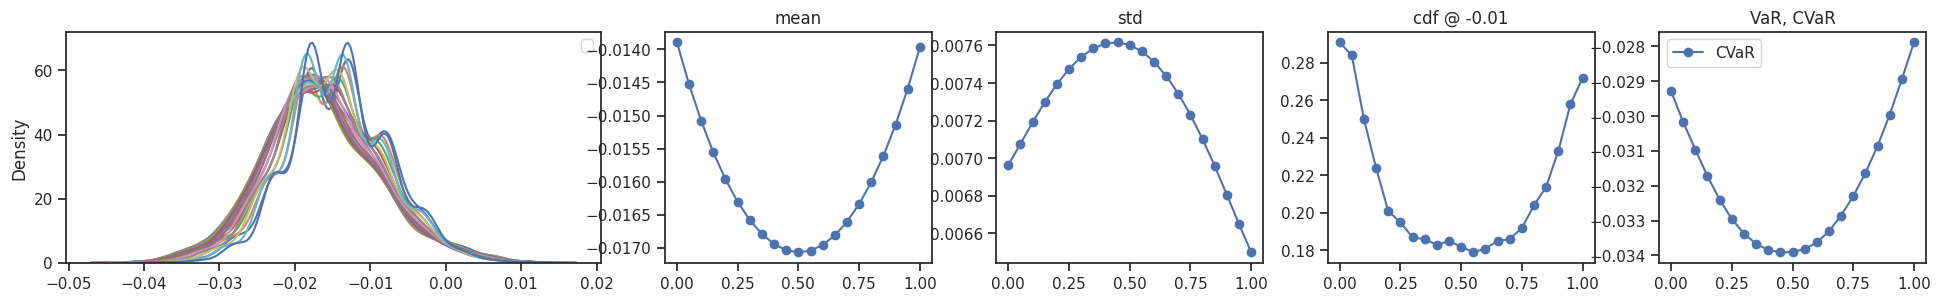

In [26]:
fig, ax = plt.subplots(figsize=(24, 3), nrows=1, ncols=5, gridspec_kw={'width_ratios': [2, 1, 1, 1, 1]}, squeeze=False)

for run in results:
    sns.kdeplot(run, ax=ax[0][0])
ax[0][0].legend()

means = np.array([np.mean(run) for run in results])
ax[0][1].plot(ws, means, marker="o", markersize="3")
ax[0][1].set_title('mean')

stds = np.array([np.std(run) for run in results])
ax[0][2].plot(ws, stds, marker="o", markersize="3")
ax[0][2].set_title('std')

cdf = np.array([np.mean(run >= -0.01) for run in results])
ax[0][3].plot(ws, cdf, marker="o", markersize="3")
ax[0][3].set_title('cdf @ -0.01')

vars = np.array([np.quantile(run, alpha) for run in results])
cvars = np.array([np.sum(run * (run <= np.quantile(run, alpha))) / np.sum(run <= np.quantile(run, alpha)) / (1 - alpha) for run in results])
# ax[0][4].plot(ws, vars, marker="o", markersize="3", label='VaR')
ax[0][4].plot(ws, cvars, marker="o", markersize="3", label='CVaR')
ax[0][4].legend()
ax[0][4].set_title('VaR, CVaR')


# Plot separately

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1361.29it/s]


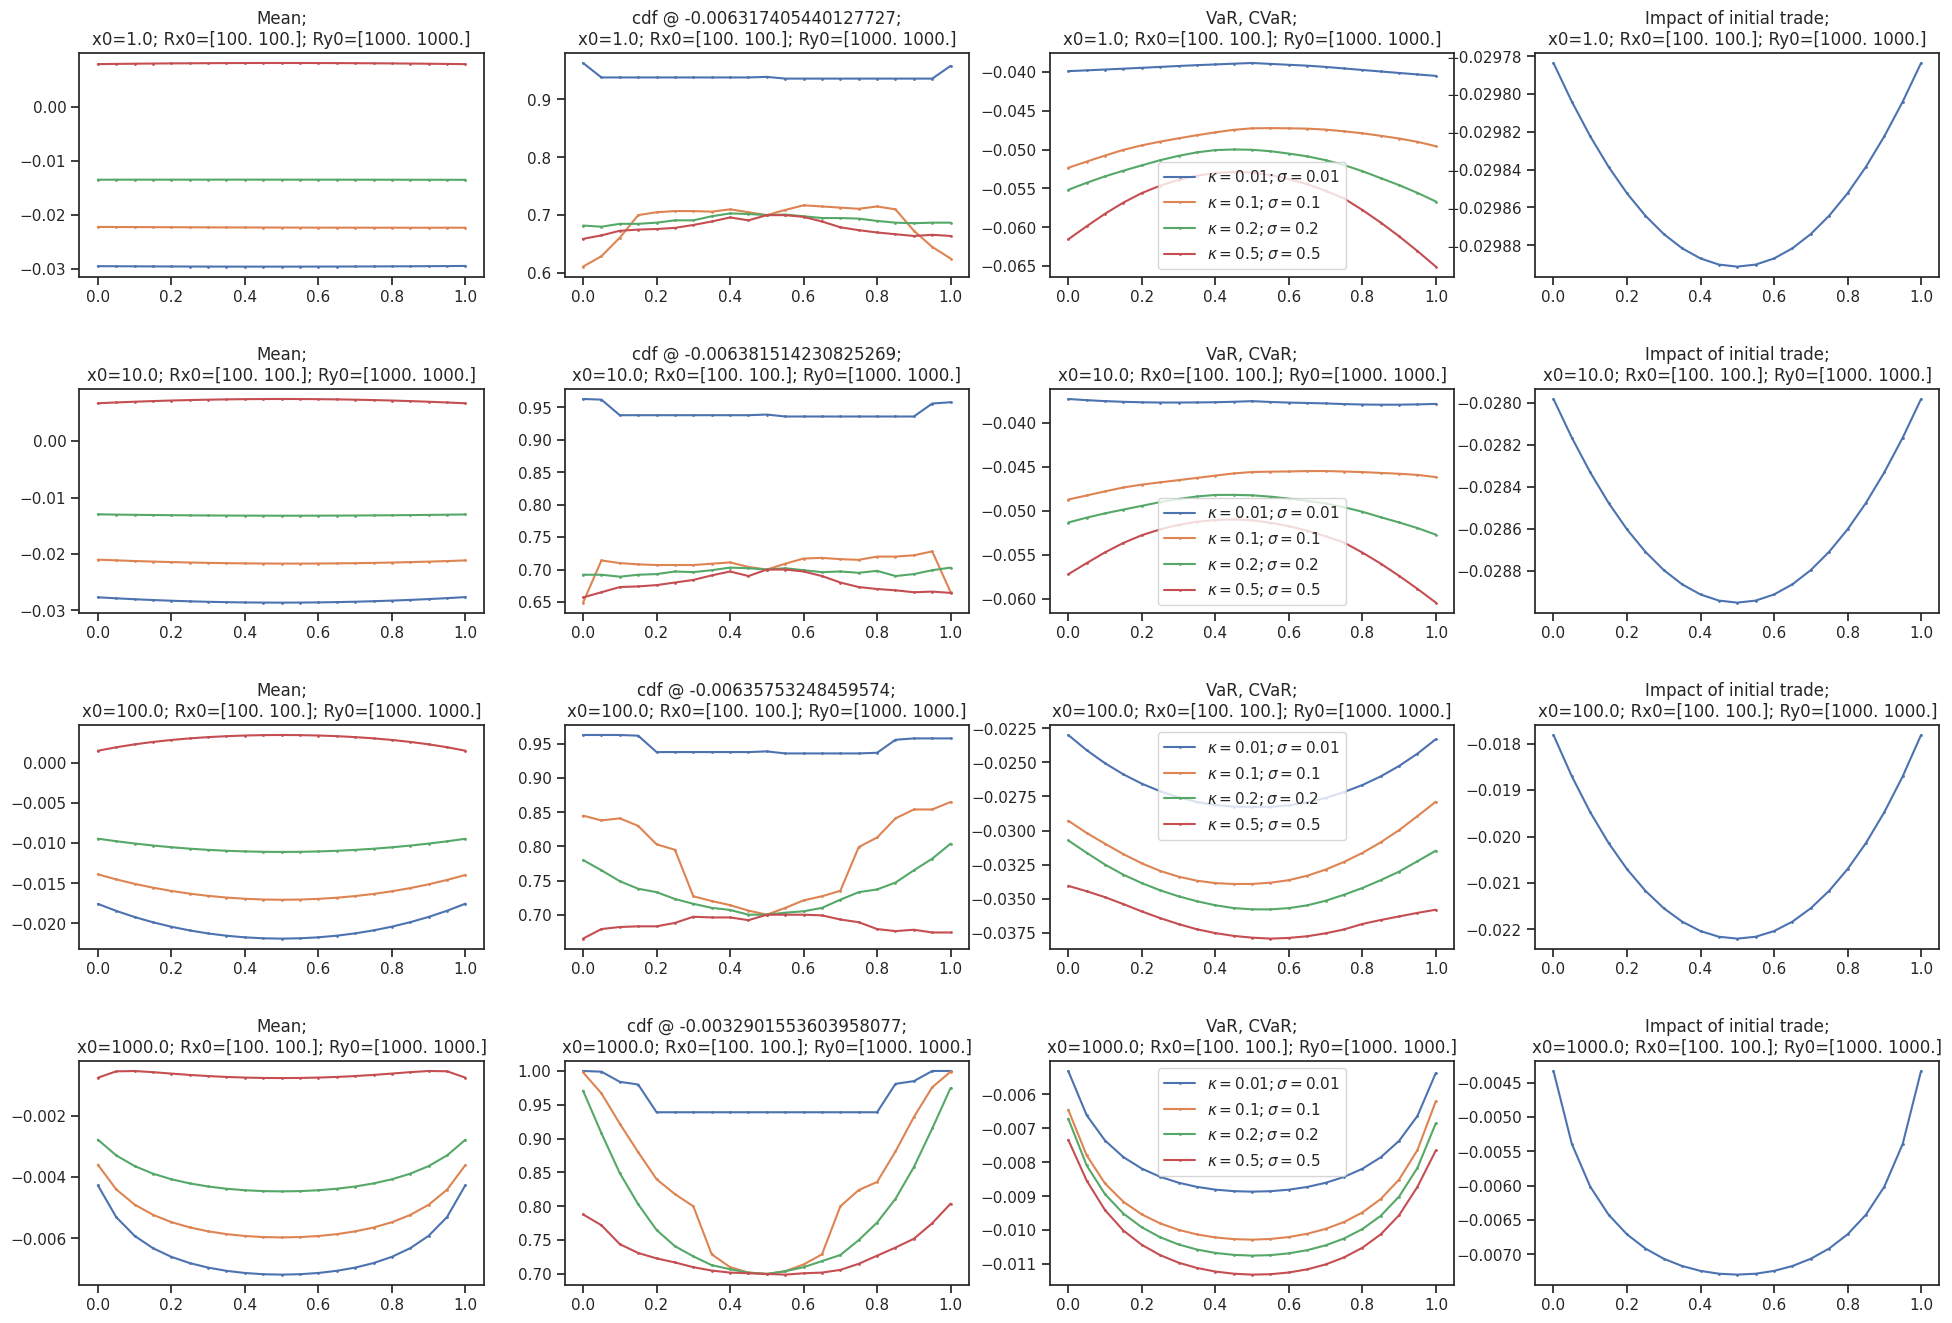

In [67]:
ws = np.linspace(1e-4, 1-1e-4, 21)
x0s = np.array([1., 10., 100., 1000.])
els = np.array([1e-2, 1e-1, 2e-1, 5e-1])

fig, ax = plt.subplots(figsize=(24, 4 * len(x0s)), nrows=len(x0s), ncols=4, gridspec_kw={'width_ratios': [1, 1, 1, 1]}, squeeze=False)
plt.subplots_adjust(hspace=0.5)

locals().update(params)

for i, x_0 in enumerate(x0s):
    
    for el in els:
        
        log_rets = []
        results = []
    
        kappa = np.repeat(el, N_pools + 1)
        sigma = np.repeat(el, N_pools + 1)

        qtl = None
        
        for j, w in enumerate(ws):
            
            pools = amm(Rx=Rx0, Ry=Ry0, phi=phi)
        
            xs_0 = x_0 * np.array([w, 1-w])
            l = pools.swap_and_mint(xs_0)
        
            np.random.seed(seed)
            end_pools, Rx_t, Ry_t, v_t, event_type_t, event_direction_t = pools.simulate(kappa, p, sigma, T=T, batch_size=batch_size)
        
            x_T = np.sum(np.array([pool.burn_and_swap(l) for pool in end_pools]), axis=1)
            log_ret = np.log(x_T) - np.log(x_0)
        
            results += [log_ret]

            # record quantile of the weight which is roughly in the middle
            if j <= len(ws) // 2:
                qtl = np.quantile(log_ret, 0.3)
                
        means = np.array([np.mean(run) for run in results])
        ax[i][0].plot(ws, means, marker="o", markersize="3", label=f"kappa, sigma = {param}")
        ax[i][0].set_title(f"Mean;\nx0={x_0}; Rx0={Rx0}; Ry0={Ry0}")
        ax[i][0].set_xlabel('w0')
        
        cdf = np.array([np.mean(run >= qtl) for run in results])
        ax[i][1].plot(ws, cdf, marker="o", markersize="3", label=f"kappa, sigma = {param}")
        ax[i][1].set_title(f"cdf @ {qtl:.4f};\nx0={x_0}; Rx0={Rx0}; Ry0={Ry0}")
        ax[i][1].set_xlabel('w0')
        
        vars = np.array([np.quantile(run, alpha) for run in results])
        cvars = np.array([np.sum(run * (run <= np.quantile(run, alpha))) / np.sum(run <= np.quantile(run, alpha)) / (1 - alpha) for run in results])
        ax[i][2].plot(ws, cvars, marker="o", markersize="3", label=f"$\kappa={el}; \sigma={el}$")
        ax[i][2].legend()
        ax[i][2].set_title(f"VaR, CVaR;\nx0={x_0}; Rx0={Rx0}; Ry0={Ry0}")
        ax[i][2].set_xlabel('w0')
    
    rs = []
    for w in ws:
        pools = amm(Rx=Rx0, Ry=Ry0, phi=phi)
        x1 = x_0 * np.array([w, 1-w])
        l = pools.swap_and_mint(x1)
        x2 = pools.burn_and_swap(l)
        rs += [np.sum(x2) - np.sum(x1)]
    
    ax[i][3].plot(ws, np.array(rs)/x_0, marker="o", markersize="3")
    ax[i][3].set_title(f"Impact of initial trade;\nx0={x_0}; Rx0={Rx0}; Ry0={Ry0}")
    ax[i][3].set_xlabel('w0')

fig.savefig(f"_output/market_impact_analysis.pdf")